In [ ]:
"""
@author:LEHOSO
"""

In [2]:
# 读取数据
#利用ImageDataGenerator构造数据生成器
from keras.preprocessing.image import ImageDataGenerator

IMSIZE = 224
# 根据花的图片数据，构造训练集数据生成器和验证集数据生成器
train_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory('../../data/data_res/train',
                                                                           target_size=(IMSIZE, IMSIZE),
                                                                           batch_size=10,
                                                                           class_mode='categorical'
                                                                           )

validation_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory('../../data/data_res/validation',
                                                                                target_size=(IMSIZE, IMSIZE),
                                                                                batch_size=10,
                                                                                class_mode='categorical')

Using TensorFlow backend.


Found 1612 images belonging to 3 classes.
Found 355 images belonging to 3 classes.


<Figure size 432x288 with 0 Axes>

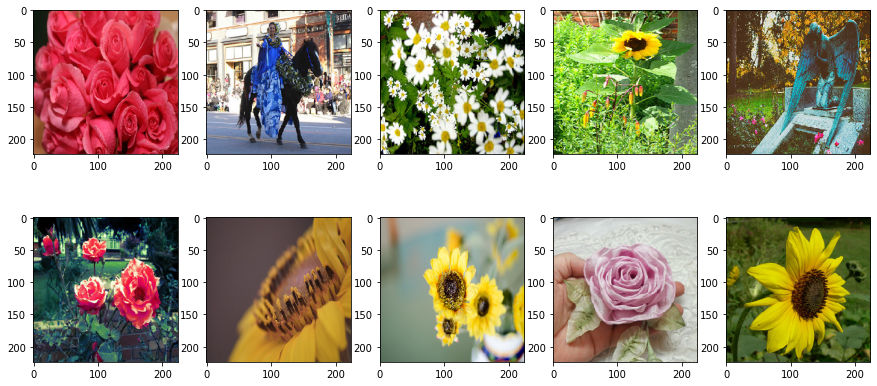

In [3]:
#显示数据
from matplotlib import pyplot as plt

plt.figure()
fig, ax = plt.subplots(2, 5)
fig.set_figheight(7)
fig.set_figwidth(15)
ax = ax.flatten()
X, Y = next(train_generator)
for i in range(10): ax[i].imshow(X[i, :, :, :])

In [4]:
# 构建模型。首先构建残差学习模块之前的网络结构。
from keras.layers import Dense, Flatten
from keras.layers import Input
from keras.layers import Activation, Conv2D, BatchNormalization, add, MaxPooling2D, AveragePooling2D
from keras import Model

NB_CLASS = 3
IM_WIDTH = 224
IM_HEIGHT = 224

input_shape = Input(shape=(IM_WIDTH, IM_HEIGHT, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu')(input_shape)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x0 = x
x0

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



<tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 56, 56, 64) dtype=float32>

In [5]:
# 接着构建残差学习模块，其中利用循环的方法进行构建完整的ResNet_50网络结构。
#conv2——x
# 一个block，第一个block里面需要更改步长
for i in range(3):
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(256, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization

    #下面两步为了把输入64通道的数据转换为256个通道，用来让x0和x维数相同
    #可以进行加法计算，文章中虚线得得部分
    x0 = Conv2D(256, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
    x0 = BatchNormalization()(x0)

    #add把输入的x和经过一个block之后输出的结果加在一起
    x = add([x, x0])
    #求和之后的结果再做一次relu
    x = Activation('relu')(x)
    x0 = x

x0

<tf.Tensor 'activation_3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>

In [6]:
#conv3——x
#第一个block
x = Conv2D(128, (1, 1), padding='same', strides=(2, 2), activation='relu')(x0)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x = Conv2D(512, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x1 = Conv2D(512, (1, 1), padding='same', strides=(2, 2), activation=None)(x0)
x1 = BatchNormalization()(x1)
#一个卷积层加一个batch normalization

#add把输入的x和经过一个block之后输出的结果加在一起
x = add([x, x1])
#求和之后的结果再做一次relu
x = Activation('relu')(x)
#把输入存到另外一个变量中
x1 = x
x1

<tf.Tensor 'activation_4/Relu:0' shape=(?, 28, 28, 512) dtype=float32>

In [7]:
#第2-4个block
for i in range(3):
    x = Conv2D(128, (1, 1), padding='same', strides=(1, 1), activation='relu')(x1)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(512, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization

    #下面两步为了把输入64通道的数据转换为256个通道，用来让x0和x维数相同
    #可以进行加法计算，文章中虚线得得部分
    #可以不用
    #x1 = Conv2D(256, (1, 1), padding='same', strides=(1, 1), activation=None)(x1)
    #x1 = BatchNormalization()(x1)

    #add把输入的x和经过一个block之后输出的结果加在一起
    x = add([x, x1])
    #求和之后的结果再做一次relu
    x = Activation('relu')(x)
    #把输入存到另外一个变量中
    x1 = x
x1

<tf.Tensor 'activation_7/Relu:0' shape=(?, 28, 28, 512) dtype=float32>

In [8]:
#conv4——x
#第一个block
x = Conv2D(256, (1, 1), padding='same', strides=(2, 2), activation='relu')(x1)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x = Conv2D(1024, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x2 = Conv2D(1024, (1, 1), padding='same', strides=(2, 2), activation=None)(x1)
x2 = BatchNormalization()(x2)
#一个卷积层加一个batch normalization

#add把输入的x和经过一个block之后输出的结果加在一起
x = add([x, x2])
#求和之后的结果再做一次relu
x = Activation('relu')(x)
#把输入存到另外一个变量中
x2 = x
x2

<tf.Tensor 'activation_8/Relu:0' shape=(?, 14, 14, 1024) dtype=float32>

In [9]:
#第2-6个block
for i in range(5):
    x = Conv2D(256, (1, 1), padding='same', strides=(1, 1), activation='relu')(x2)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(1024, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization

    #下面两步为了把输入64通道的数据转换为256个通道，用来让x0和x维数相同
    #可以进行加法计算，文章中虚线得得部分
    #可以不用
    #x2 = Conv2D(256, (1, 1), padding='same', strides=(1, 1), activation=None)(x2)
    #x2 = BatchNormalization()(x2)

    #add把输入的x和经过一个block之后输出的结果加在一起
    x = add([x, x2])
    #求和之后的结果再做一次relu
    x = Activation('relu')(x)
    #把输入存到另外一个变量中
    x2 = x
x2

<tf.Tensor 'activation_13/Relu:0' shape=(?, 14, 14, 1024) dtype=float32>

In [91]:
#conv5——x
#第一个block
x = Conv2D(512, (1, 1), padding='same', strides=(2, 2), activation='relu')(x2)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x = Conv2D(2048, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
x = BatchNormalization()(x)
#一个卷积层加一个batch normalization

x3 = Conv2D(2048, (1, 1), padding='same', strides=(2, 2), activation=None)(x2)
x3 = BatchNormalization()(x3)
#一个卷积层加一个batch normalization

#add把输入的x和经过一个block之后输出的结果加在一起
x = add([x, x3])
#求和之后的结果再做一次relu
x = Activation('relu')(x)
#把输入存到另外一个变量中
x3 = x
x3

<tf.Tensor 'activation_103/Relu:0' shape=(?, 7, 7, 2048) dtype=float32>

In [92]:
#第2-6个block
for i in range(2):
    x = Conv2D(512, (1, 1), padding='same', strides=(1, 1), activation='relu')(x3)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization
    x = Conv2D(2048, (1, 1), padding='same', strides=(1, 1), activation=None)(x)
    x = BatchNormalization()(x)
    #一个卷积层加一个batch normalization

    #下面两步为了把输入64通道的数据转换为256个通道，用来让x0和x维数相同
    #可以进行加法计算，文章中虚线得得部分
    #可以不用
    #x3 = Conv2D(256, (1, 1), padding='same', strides=(1, 1), activation=None)(x3)
    #x3 = BatchNormalization()(x3)

    #add把输入的x和经过一个block之后输出的结果加在一起
    x = add([x, x3])
    #求和之后的结果再做一次relu
    x = Activation('relu')(x)
    #把输入存到另外一个变量中
    x3 = x
x3

<tf.Tensor 'activation_105/Relu:0' shape=(?, 7, 7, 2048) dtype=float32>

In [93]:
#在reset最后的部分添加一个dense层，并输出一个二维的结果用来分类
x = x3
x = AveragePooling2D(pool_size=(7, 7), padding="same")(x)
x = Flatten()(x)
predictions = Dense(NB_CLASS, activation='softmax')(x)
model_res = Model(inputs=input_shape, outputs=predictions)
model_res.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_318 (Conv2D)             (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_318 (BatchN (None, 112, 112, 64) 256         conv2d_318[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_318[0][0]    
____________________________________________________________________________________________

In [10]:
# 模型编译。利用compile函数实现。
from keras.optimizers import Adam

model_res.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

NameError: name 'model_res' is not defined

In [95]:
#模型拟合。利用fit_generator进行拟合，并观察循环过程中，参数的变化。
model_res.fit_generator(train_generator,
                        steps_per_epoch=100,
                        epochs=5,
                        validation_data=validation_generator,
                        validation_steps=100)

Epoch 1/5
100/100 [==============================] - 48s 478ms/step - loss: 2.6171 - accuracy: 0.4460 - val_loss: 2.2929 - val_accuracy: 0.4120
Epoch 2/5
100/100 [==============================] - 35s 346ms/step - loss: 1.5186 - accuracy: 0.4427 - val_loss: 1.2176 - val_accuracy: 0.4500
Epoch 3/5
100/100 [==============================] - 35s 346ms/step - loss: 1.3092 - accuracy: 0.4920 - val_loss: 1.6637 - val_accuracy: 0.3940
Epoch 4/5
100/100 [==============================] - 35s 346ms/step - loss: 1.1012 - accuracy: 0.5500 - val_loss: 0.3944 - val_accuracy: 0.5080
Epoch 5/5
100/100 [==============================] - 34s 339ms/step - loss: 0.9847 - accuracy: 0.6200 - val_loss: 0.5374 - val_accuracy: 0.6380
